In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pingouin as pg

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.outliers_influence as sms
from statsmodels.tools.tools import add_constant

from patsy.contrasts import ContrastMatrix
from patsy.contrasts import Poly
%matplotlib inline

In [3]:
data = pd.read_csv('../Data_Files/Superhero.dat' , sep='\t')
data.head()

,hero,injury
0,1,51
1,1,31
2,1,58
3,1,20
4,1,47


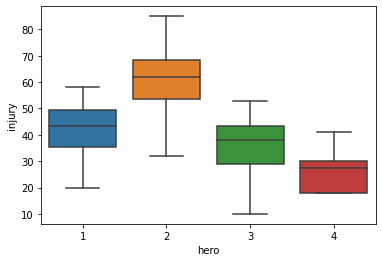

In [4]:
_ = sns.boxplot(x='hero', y='injury', data=data)

In [5]:
data_1 = data[data['hero']==1]
data_2 = data[data['hero']==2]
data_3 = data[data['hero']==3]
data_4 = data[data['hero']==4]

In [6]:
stat, p = st.levene(data_1['injury'], data_2['injury'], data_3['injury'], data_4['injury'])
print(stat, p)

0.8269751995286303 0.4910160327502844


In [7]:
m01 = ols('injury~C(hero)', data=data).fit()
m01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 injury   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     8.317
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           0.000483
Time:                        13:30:22   Log-Likelihood:                -117.24
No. Observations:                  30   AIC:                             242.5
Df Residuals:                      26   BIC:                             248.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       41.6250      4.577      9.095      0.000      32.218      51.032
C(hero)[T.2]    18.7083      6.991      2.676      0.013       4.338      33.078
C(hero)[T.3]    -6.2500      6.472     -0.966      0.343     -19.554       7.054
C(hero)[T.4]   -15.3750      6.472     -2.376      0.025     -28.679      -2.071
==============================================================================
Omnibus:                        1.483   Durbin-Watson:                   2.922
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                0.866
Skew:                          -0.415   Prob(JB):                        0.649
Kurtosis:                       3.060   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
anova_table = sm.stats.anova_lm(m01)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(hero),3.0,4180.616667,1393.538889,8.316612,0.000483
Residual,26.0,4356.583333,167.560897,NaN,NaN


#### # In the ANOVA output above, the observed significance value is less than .05 and so we can say that there was a significant effect of superhero costume on injury severity. However, at this stage we still do not know exactly what the effect of superhero costume was (we don’t know which groups differed). Because there were no specific hypotheses, only that the groups would differ, we can’t look at planned contrasts but we can conduct some post hoc tests. I am going to conduct a Benjamini–Hochberg (BH) test by executing

In [9]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

In [10]:
multicomp = MultiComparison(data['injury'], data['hero'])   # testfunc

In [11]:
# Benjamini-Hochberg
com_bh = multicomp.allpairtest(st.ttest_ind, method='fdr_bh')
print(com_bh[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=fdr_bh
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     1      2 -2.3367 0.0376    0.0564  False
     1      3  0.9757 0.3458    0.3458  False
     1      4  2.9615 0.0103    0.0221   True
     2      3  3.0002 0.0111    0.0221   True
     2      4  4.8181 0.0004    0.0025   True
     3      4  1.6468 0.1219    0.1462  False
---------------------------------------------


In [12]:
# Holm's
com_holm= multicomp.allpairtest(st.ttest_ind, method='holm')
print(com_holm[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=holm
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     1      2 -2.3367 0.0376    0.1128  False
     1      3  0.9757 0.3458    0.3458  False
     1      4  2.9615 0.0103    0.0515  False
     2      3  3.0002 0.0111    0.0515  False
     2      4  4.8181 0.0004    0.0025   True
     3      4  1.6468 0.1219    0.2437  False
---------------------------------------------


In [13]:
# Bonf
com_bonf= multicomp.allpairtest(st.ttest_ind, method='bonf')
print(com_bonf[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     1      2 -2.3367 0.0376    0.2256  False
     1      3  0.9757 0.3458       1.0  False
     1      4  2.9615 0.0103    0.0619  False
     2      3  3.0002 0.0111    0.0664  False
     2      4  4.8181 0.0004    0.0025   True
     3      4  1.6468 0.1219    0.7311  False
---------------------------------------------


#### # Doing all three post hoc test , we can see where the difference lie.
#### # Note: The Statistical Power of these three post-hoc test are as follows fdr_bh > holm > bonf, which is pretty evident pval_corr.

## Calculating the effect size

In [14]:
SSm = 4180.616667
SSr = 4356.58
SSt = SSm+SSr

In [15]:
MSm = 1393.538889
MSr = 167.56

In [16]:
ω_squared = (SSm-3*MSr)/(SSt+MSr)   # here ω_squared is like adjusted R_squared
ω_squared

0.4225203308603871

In [17]:
ω = np.sqrt(ω_squared)       # ω, more accurate measure of R
ω

0.6500156389352391

### Final reporting:
#### # All significant values are reported at p < .05.There was a significant effect of superhero costume on severity of injury, F(3, 26) = 8.32, ω2 = .42. Benjamini–Hochberg tests revealed wearing a Superman costume resulted in significantly more severe injuries than Ninja Turtle and Hulk costumes, all ps < .05. Wearing a Spiderman costume resulted in significantly more severe injuries than wearing a Ninja Turtle costume p < .05 but not significantly more severe injuries than wearing a Hulk costume p = .34. Wearing a Hulk costume did not result in significantly more severe injuries than wearing a Ninja Turtle costume,p = 0.1462